In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

Load and preprocess dataset


In [19]:
def load_mnist(binary_classification=True):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    if binary_classification:
        train = [(x, float(y == 0)) for x, y in train]
        test = [(x, float(y == 0)) for x, y in test]

    train_loader = DataLoader(train, batch_size=64, shuffle=True)
    test_loader = DataLoader(test, batch_size=64, shuffle=False)
    return train_loader, test_loader


Logistic Regression Model

In [20]:
class LogisticRegressionModel:
    def __init__(self, input_dim):
        self.w = np.zeros((input_dim, 1))
        self.b = 0

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        return self.sigmoid(X @ self.w + self.b)

    def loss(self, X, y):
        m = len(y)
        preds = self.predict(X)
        loss = -np.mean(y * np.log(preds + 1e-8) + (1 - y) * np.log(1 - preds + 1e-8))
        return loss

    def gradient(self, X, y):
        m = len(y)
        preds = self.predict(X)
        error = preds - y
        dw = (X.T @ error) / m
        db = np.mean(error)
        return dw, db

 SGD Optimizer (Student: extend this)

In [21]:
def sgd_train(model, train_loader, lr=0.01, num_epochs=10):
    loss_history = []

    for epoch in range(num_epochs):
        for batch in train_loader:
            x_batch, y_batch = batch
            X = x_batch.numpy()
            y = y_batch.numpy().reshape(-1, 1)

            dw, db = model.gradient(X, y)
            model.w -= lr * dw
            model.b -= lr * db

            loss = model.loss(X, y)
            loss_history.append(loss)

    return loss_history

This next training function will incorporate momentum, it will maintain a velovity for <br>
weights and bias. Parameters will be updated based on the velocity. <br><br>

Velocity starts at 0, they will accumulate over time.

What happens is each batch wil calc the gradients, update the velocities, update model <br>
perameters using new velocities.
Then we record the loss after each update.

In [22]:
def sgd_train_momentum(model, train_loader, lr=0.01, momentum=0.9, num_epochs=10):
    loss_history = []
    # Thevelocities for weight and biases
    velocity_w = np.zeros_like(model.w)
    velocity_b = 0.0

    for epoch in range(num_epochs):
        for batch in train_loader:
            x_batch, y_batch = batch
            X = x_batch.numpy()
            y = y_batch.numpy().reshape(-1, 1)

            # get gradient
            dw, db = model.gradient(X, y)
            
            # new velocities
            velocity_w = momentum * velocity_w + dw
            velocity_b = momentum * velocity_b + db
            
            # new perams using velocities
            model.w -= lr * velocity_w
            model.b -= lr * velocity_b

            # loss :(
            loss = model.loss(X, y)
            loss_history.append(loss)

    return loss_history

Evaluate function takes in trained model and batches of input data. <br>
Then it counts how many predictions match labels and gived a total of processed data

In [23]:
def evaluate(model, data_loader):
    total = 0
    correct = 0
    for x_batch, y_batch in data_loader:
        X = x_batch.numpy()
        y = y_batch.numpy().reshape(-1, 1)
        preds = model.predict(X)  # Probability
        preds_label = (preds >= 0.5).astype(float)
        correct += (preds_label == y).sum()
        total += len(y)
    return correct / total

Explore a decreasing learn rate to see how dynamic learning rate schedules affect convergence<br>
Mode will take large initial steps and then transition to smaller adjustments as convergence<br>
nears<br><br>

takes in a model, training data, initial learning rate (alpha), decay controll factor (lamba)<br>
The function loops through the entire dataset, while in each datset loop, smaller batches are<br>
also looped through, the learn rate is calced for each batch, gradient is calculated with <br>
weights and bias taken into consideration.

In [24]:
def sgd_train_decreasing_lr(model, train_loader, alpha0=0.1, lambda_=0.001, num_epochs=5):
    loss_history = []
    t = 0  #counter
    for epoch in range(num_epochs):
        for batch in train_loader:
            t += 1
            # lern rate
            lr = alpha0 / (1 + lambda_ * t)
            
            x_batch, y_batch = batch
            X = x_batch.numpy()
            y = y_batch.numpy().reshape(-1, 1)
            
            # Comp gradient
            dw, db = model.gradient(X, y)
            # new params calced using learn rate
            model.w -= lr * dw
            model.b -= lr * db
            
            # loss
            loss = model.loss(X, y)
            loss_history.append(loss)
    
    return loss_history

Adam optimizer,
Initializes moment estimates and time step, moment 1 (m) keeps track of gradient <br>
moment 2 (v) tracks variance. And the time step (t) will be for bias correction<br><br>

We loop through data and for each batch:<br>
we increment t by 1, compute gradients, we update moment 1 and 2.

In [25]:
def adam_train(model, train_loader, lr=0.001, beta1=0.9, beta2=0.99, epsilon=1e-8, num_epochs=5, bias_correction=True):
    loss_history = []
    # Initialize first moment and second moment for weights and bias
    m_w = np.zeros_like(model.w)
    v_w = np.zeros_like(model.w)
    m_b = 0.0
    v_b = 0.0
    t = 0
    
    for epoch in range(num_epochs):
        for batch in train_loader:
            t += 1
            x_batch, y_batch = batch
            X = x_batch.numpy()
            y = y_batch.numpy().reshape(-1, 1)
            
            # gradient comp
            dw, db = model.gradient(X, y)
            
            # Update moment 1
            m_b = beta1 * m_b + (1 - beta1) * db
            m_w = beta1 * m_w + (1 - beta1) * dw
                        
            # Update moment 2
            v_b = beta2 * v_b + (1 - beta2) * (db ** 2)
            v_w = beta2 * v_w + (1 - beta2) * (dw ** 2)
                        
            if bias_correction:
                v_w_hat = v_w / (1 - beta2 ** t)
                v_b_hat = v_b / (1 - beta2 ** t)
                m_b_hat = m_b / (1 - beta1 ** t)
                m_w_hat = m_w / (1 - beta1 ** t)
                 
            else:
                # if no bias correction
                m_w_hat = m_w
                m_b_hat = m_b
                v_w_hat = v_w
                v_b_hat = v_b
            
            model.w -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
            model.b -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)
            
            #loss
            loss = model.loss(X, y)
            loss_history.append(loss)
    
    return loss_history

Plotting and Evaluation

In [26]:
def plot_loss(losses, label='SGD'):
    plt.plot(losses, label=label)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss vs Iteration")
    plt.legend()

 Main Function

Implementing with fixed learning rate

This model trains using a basic regeression model. Good baseline.

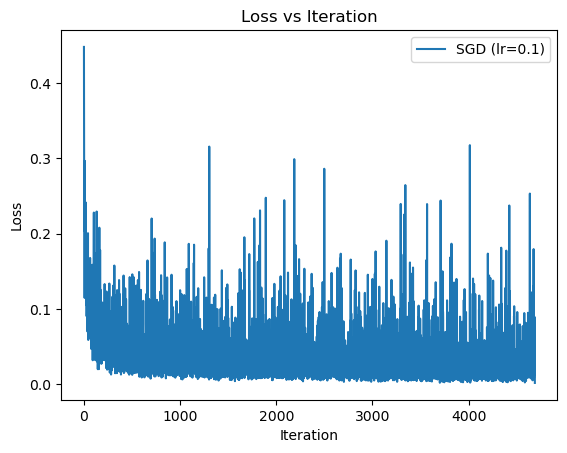

In [11]:
if __name__ == '__main__':
    train_loader, test_loader = load_mnist()
    input_dim = 28 * 28

    # Vanilla SGD with fixed learning rate (Task 0)
    model_sgd = LogisticRegressionModel(input_dim=input_dim)
    loss_sgd = sgd_train(model_sgd, train_loader, lr=0.1, num_epochs=5)
    plot_loss(loss_sgd, label='SGD (lr=0.1)')
    plt.show()


Here we will loop through constant learning rates to train models,
in doing so we see how each contant affects stability and 
convergence speed.

-Task 1-

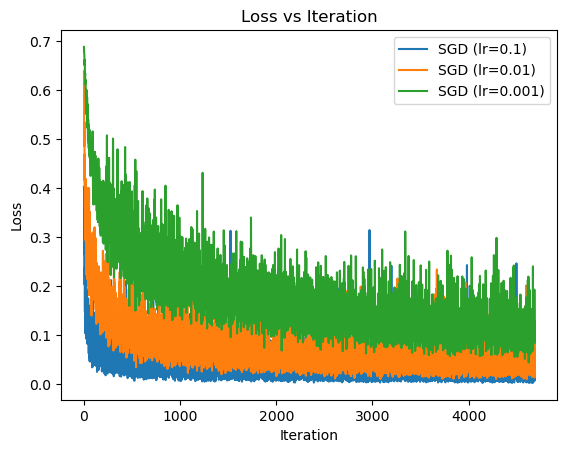

In [12]:
if __name__ == '__main__':
    train_loader, test_loader = load_mnist()
    input_dim = 28 * 28
    
    # const learn rates
    constant_lrs = [0.1, 0.01, 0.001]
    
    for lr in constant_lrs:
        model_const = LogisticRegressionModel(input_dim=input_dim)
        loss_const = sgd_train(model_const, train_loader, lr=lr, num_epochs=5)
        plot_loss(loss_const, label=f'SGD (lr={lr})')
    
    plt.legend()
    plt.show()


Here we run training with a SGD and use a learning rate schedule. The LR schedule
decreases with time.

Helps visualize effect of an adapting learning rate which helps conclude whether decaying 
learning rate improves convergance.

-Task 1-

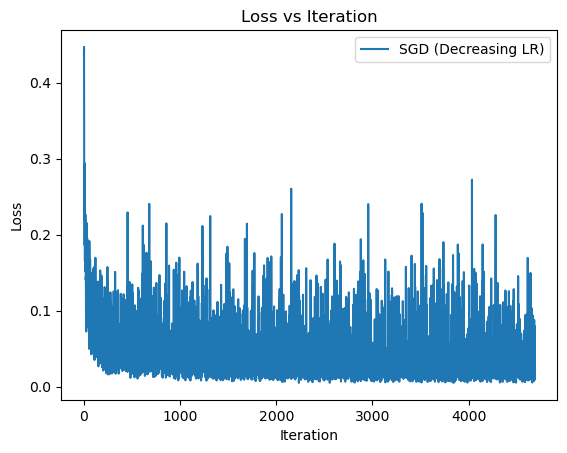

In [13]:
# decreasing learning rate
if __name__ == '__main__':
    train_loader, test_loader = load_mnist()
    input_dim = 28 * 28
    
    # Run with decreasing learning rate
    model_decr = LogisticRegressionModel(input_dim=input_dim)
    loss_decr = sgd_train_decreasing_lr(model_decr, train_loader, alpha0=0.1, lambda_=0.001, num_epochs=5)
    plot_loss(loss_decr, label='SGD (Decreasing LR)')
    
    plt.legend()
    plt.show()

Comparing vanilla SGD to momentum SGD.
Here we try to test whether momentum has better convergence.

-Task 2-

Final loss (Vanilla SGD): 0.08656436052354327
Final loss (Momentum SGD): 0.025288956714591613
Test Accuracy (Vanilla SGD): 0.9919
Test Accuracy (Momentum SGD): 0.9914


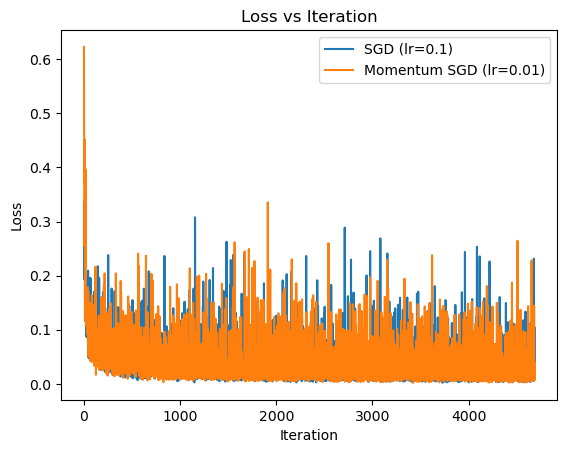

In [14]:
if __name__ == '__main__':
    train_loader, test_loader = load_mnist()
    input_dim = 28 * 28

    model_sgd = LogisticRegressionModel(input_dim=input_dim)
    loss_sgd = sgd_train(model_sgd, train_loader, lr=0.1, num_epochs=5)
    plot_loss(loss_sgd, label='SGD (lr=0.1)')

    model_momentum = LogisticRegressionModel(input_dim=input_dim)
    loss_momentum = sgd_train_momentum(model_momentum, train_loader, lr=0.01, momentum=0.9, num_epochs=5)
    plot_loss(loss_momentum, label='Momentum SGD (lr=0.01)')

    print("Final loss (Vanilla SGD):", loss_sgd[-1])
    print("Final loss (Momentum SGD):", loss_momentum[-1])

    test_acc_sgd = evaluate(model_sgd, test_loader)
    test_acc_momentum = evaluate(model_momentum, test_loader)
    print("Test Accuracy (Vanilla SGD):", test_acc_sgd)
    print("Test Accuracy (Momentum SGD):", test_acc_momentum)


    plt.legend()
    plt.show()

next we compare and find out how bias correction affects convergence within Adam.
Final loss is also compared to assess which version is more affective.

-Task 3-

Final loss (Adam no BC): 0.0030677925972157666
Final loss (Adam with BC): 0.030446869483864387


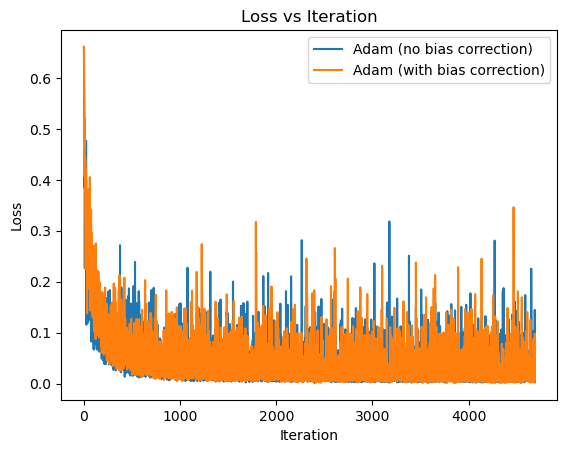

In [29]:
if __name__ == '__main__':
    train_loader, test_loader = load_mnist()
    input_dim = 28 * 28

    # adam no bias correction
    model_adam_no_bc = LogisticRegressionModel(input_dim=input_dim)
    loss_adam_no_bc = adam_train(model_adam_no_bc, train_loader, lr=0.001, num_epochs=5, bias_correction=False)
    plot_loss(loss_adam_no_bc, label='Adam (no bias correction)')

    # Adam with correction
    model_adam_bc = LogisticRegressionModel(input_dim=input_dim)
    loss_adam_bc = adam_train(model_adam_bc, train_loader, lr=0.001, num_epochs=5, bias_correction=True)
    plot_loss(loss_adam_bc, label='Adam (with bias correction)')

    print("Final loss (Adam no BC):", loss_adam_no_bc[-1])
    print("Final loss (Adam with BC):", loss_adam_bc[-1])


    plt.legend()
    plt.show()


Here we retrain all models using the 4 methods and evaulate them.

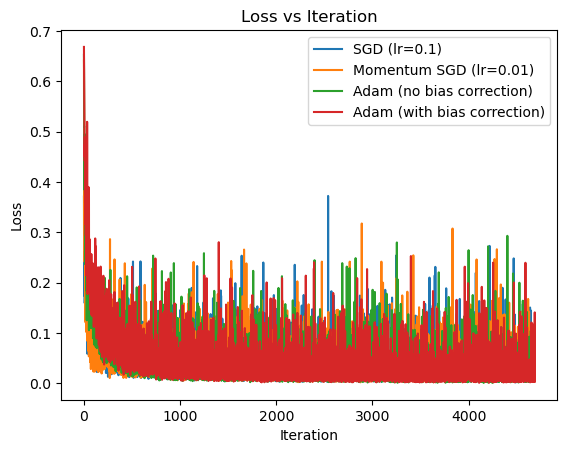

Test Accuracy (Vanilla SGD): 0.9917
Test Accuracy (Momentum SGD): 0.9922
Test Accuracy (Adam without Bias Correction): 0.9927
Test Accuracy (Adam with Bias Correction): 0.9933


In [30]:
if __name__ == '__main__':
    train_loader, test_loader = load_mnist()
    input_dim = 28 * 28
    
    # Vanilla SGD
    model_sgd = LogisticRegressionModel(input_dim=input_dim)
    loss_sgd = sgd_train(model_sgd, train_loader, lr=0.1, num_epochs=5)
    plot_loss(loss_sgd, label='SGD (lr=0.1)')
    
    # Momentum SGD
    model_momentum = LogisticRegressionModel(input_dim=input_dim)
    loss_momentum = sgd_train_momentum(model_momentum, train_loader, lr=0.01, momentum=0.9, num_epochs=5)
    plot_loss(loss_momentum, label='Momentum SGD (lr=0.01)')
    
    # Adam no correction
    model_adam_no_bc = LogisticRegressionModel(input_dim=input_dim)
    loss_adam_no_bc = adam_train(model_adam_no_bc, train_loader, lr=0.001, num_epochs=5, bias_correction=False)
    plot_loss(loss_adam_no_bc, label='Adam (no bias correction)')
    
    # Adam correction
    model_adam_bc = LogisticRegressionModel(input_dim=input_dim)
    loss_adam_bc = adam_train(model_adam_bc, train_loader, lr=0.001, num_epochs=5, bias_correction=True)
    plot_loss(loss_adam_bc, label='Adam (with bias correction)')
    
    plt.legend()
    plt.show()
    
    # accuracy of models
    test_acc_sgd = evaluate(model_sgd, test_loader)
    test_acc_momentum = evaluate(model_momentum, test_loader)
    test_acc_adam_no_bc = evaluate(model_adam_no_bc, test_loader)
    test_acc_adam_bc = evaluate(model_adam_bc, test_loader)
    
    print("Test Accuracy (Vanilla SGD):", test_acc_sgd)
    print("Test Accuracy (Momentum SGD):", test_acc_momentum)
    print("Test Accuracy (Adam without Bias Correction):", test_acc_adam_no_bc)
    print("Test Accuracy (Adam with Bias Correction):", test_acc_adam_bc)
